# Sequential Gaussian Simulation

This exercise does not require you to programm anything. However, it is way more sophisticated from a software development perspective. So take your time to try to understand what is happening.


In [1]:
pip install rioxarray scikit-gstat gstools gstatsim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 6.1 MB/s eta 0:00:00


In [2]:
from  google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pathlib import Path

PATH = Path('/content/drive/MyDrive/Geostatistics/content/data')

## Load the data

Load the data as we used to.

In [4]:
import pandas as pd

data = pd.read_csv(PATH / 'precipitation_sums_2023-10-01.csv')
data = data.where(data.state == 'Bayern').dropna()

data

,station_id,start_date,end_date,latitude,longitude,height,name,state,geometry,value,quality
1,73.0,1952-07-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.6183,13.0620,374.0,Aldersbach-Kramersepp,Bayern,POINT (13.062 48.6183),42.7,3.0
6,142.0,1955-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.4060,11.3117,511.0,Altomünster-Maisbrunn,Bayern,POINT (11.3117 48.406),41.9,3.0
7,151.0,1955-03-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,49.4691,11.8546,382.0,Amberg-Unterammersricht,Bayern,POINT (11.8546 49.4691),35.9,3.0
8,154.0,1994-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.0197,12.2925,516.0,Amerang-Pfaffing,Bayern,POINT (12.2925 48.0197),48.0,3.0
13,191.0,1884-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,49.9694,9.9114,217.0,Arnstein-Müdesheim,Bayern,POINT (9.9114 49.9694),90.7,3.0
...,...,...,...,...,...,...,...,...,...,...,...
420,7395.0,2007-12-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.6595,12.5388,351.0,Gottfrieding,Bayern,POINT (12.5388 48.6595),38.7,3.0
426,7424.0,2006-12-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,47.7724,12.9073,457.0,Piding,Bayern,POINT (12.9073 47.7724),49.0,3.0
429,7431.0,2007-11-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.0130,11.5524,604.0,Oberhaching-Laufzorn,Bayern,POINT (11.5524 48.013),62.9,3.0
435,13710.0,2008-04-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.5734,12.2576,490.0,Landshut-Reithof,Bayern,POINT (12.2576 48.5734),47.5,3.0


In [5]:
import pyproj
import numpy as np

# create a transform and apply
src = pyproj.CRS.from_epsg(4326)
tgt = pyproj.CRS.from_epsg(25832)
transform = pyproj.Transformer.from_crs(src, tgt, always_xy=True)
tuples = transform.transform(data.longitude.values, data.latitude.values)

# create the coordinates and values list
coordinates = np.fromiter(zip(*tuples), dtype=np.dtype((float, 2)))
values = data.value.values

Here, we load the DEM again, but just to get the same grid

In [6]:
# load the data
import rioxarray
import xarray as xr

bawu = xr.open_dataset(PATH / 'dem_bw.tif', mask_and_scale=True, chunks='auto')
# export to dataframe, use ony coords and band_data -> remove nans
dem_arr = bawu.to_dataframe().reset_index()[['x', 'y', 'band_data']]#.dropna()
# apply transformation
tuples = transform.transform(dem_arr.x.values, dem_arr.y.values)

# create the coordinates and values list
grid_coords = np.fromiter((zip(*tuples)), dtype=np.dtype((float, 2)))
print(grid_coords)

# create a mask for the locations at which we actually need a prediction
mask = ~np.isnan(dem_arr.band_data.values)
print(mask)

[[ 393068.93446185 5516243.81725904]
 [ 393049.15626462 5515245.12202547]
 [ 393029.38071829 5514246.42824436]
 ...
 [ 611941.17912076 5267616.93772061]
 [ 611960.31139593 5266618.60611887]
 [ 611979.44089871 5265620.27598293]]
[False False False ... False False False]


Create a variogram

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   383638.00
Sill:              799.82
Nugget:            43.69
        


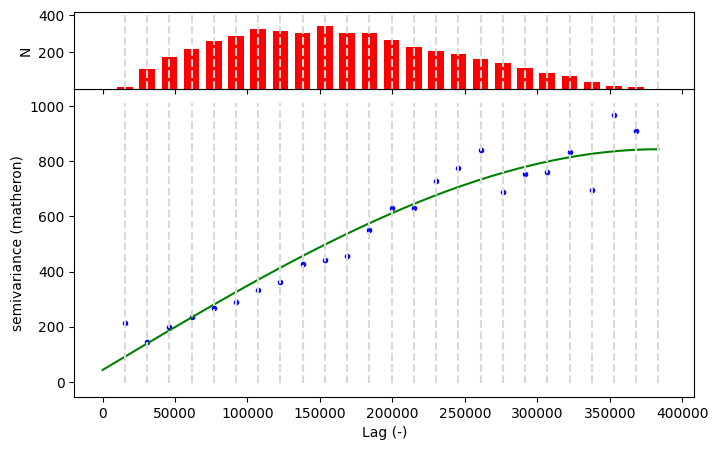

In [7]:
import skgstat as skg

vario = skg.Variogram(coordinates, values, n_lags=25, model='spherical', max_lag=350_000, use_nugget=True)

print(vario)
fig = vario.plot()

## Implement  Ordinary


This is the SGS implementation. The code is functional, there are no adjustments needed. Try to understand the logic behind the implementation.

In [ ]:
from typing import Callable
import numpy as np
from skgstat import Variogram
from scipy.spatial.distance import pdist, cdist, squareform
from scipy.spatial import KDTree
from scipy.linalg import inv
from tqdm import tqdm

from math import sqrt


class OK:

  def __init__(self, max_n: int = 15, verbose: bool = True):
    self.max_n = max_n
    self.verbose = verbose

    # set the stuff that has to be fitted
    self.variogram = None

  def fit(self, variogram: Variogram, cond_coords: np.ndarray = None, cond_vals: np.ndarray = None):
    # set the variogram params
    self.variogram = variogram

    self.eff_range = variogram.parameters[0]
    self.obs_coords = self.variogram.coordinates if cond_coords is None else cond_coords
    self.obs_values = self.variogram.values if cond_vals is None else cond_vals

    return self

  def predict(self, coordinates: np.ndarray, mask: np.ndarray = None, mp: bool = False):
    if not self._isvalid:
      raise RuntimeError("This OK instance has not been fitted to a variogram. Call OK.fit and pass variogram and drift data")

    # create a mask of True, if none is given
    if mask is None:
      mask = np.ones(len(coordinates), dtype=bool)

    # if no multiprocessing, it's easy
    if not mp:
      # create a map on the grid
      grid_map = map(self._p_krig, coordinates, mask)
      if self.verbose:
        grid_map = tqdm(grid_map, total=len(coordinates))

      con = np.fromiter(grid_map, dtype=np.dtype((float, 2)))

      return con[:, 0], con[:, 1]

    else:
      raise NotImplementedError("Multiprocessing not implemented")

  @property
  def _isvalid(self):
    if self.variogram is None:
      return False
    return True

  def _select_observations_by_range(self, p0):
    if not self._isvalid:
      raise RuntimeError("This OK instance has not been fitted to a variogram. Call OK.fit and pass variogram and drift data")

    # use a KDTree
    tree = KDTree(self.obs_coords)
    _, indices = tree.query(p0, k=self.max_n)

    return self.obs_coords[indices], self.obs_values[indices]

  def _create_C(self, p0, coords: np.ndarray):
    if not self._isvalid:
      raise RuntimeError("This OK instance has not been fitted to a variogram. Call OK.fit and pass variogram and drift data")

    # create the kriging matrix
    # get the fitted model from the variogram and push in the distance matrix
    gam = self.variogram.fitted_model(pdist(coords))

    # create the matrix and fill with ones
    C = np.ones((len(coords) + 1, len(coords) + 1))

    # now copy in the variogram
    C[:-1, :-1] = squareform(gam)

    # set the 0
    C[-1, -1] = 0

    return C

  def _create_b(self, p0, coords: np.ndarray):
    if not self._isvalid:
      raise RuntimeError("This OK instance has not been fitted to a variogram. Call OK.fit and pass variogram and drift data")

    # get the distances
    dists = cdist(coords, [p0]).flatten()

    # insert the variogram
    b = self.variogram.fitted_model(dists)

    # append the lagrange multiplier
    b = np.append(b, [1])

    return b

  def _p_krig(self, p0, p0_mask: float, coords = None, vals = None):
    # check the mask
    if not p0_mask:
      return np.nan, np.nan

    # get the neighbors
    # for p0, get the neighboring points
    if coords is None or vals is None:
      coords, vals = self._select_observations_by_range(p0)

    # if there are less than 3 points, return nan
    if len(coords) < 3:
      return np.nan, np.nan

    # create the kriging matrix
    C = self._create_C(p0, coords)

    # create the result vector
    b = self._create_b(p0, coords)

    # solve the kriging matrix
    try:
      w = inv(C).dot(b)
    except Exception as e:
      print(f"Error at ({p0[0]} {p0[1]}): {str(e)}")
      return np.nan, np.nan

    # get the weights
    pred = np.sum(w[:-1] * vals)

    # formula is nugget - wighted average of covariates plus lagrange multipliers
    var = np.sum(w[:-1] * b[:-1]) + w[-1]

    return pred, var

## Ordinary Kriging application


In [ ]:
# x, y = transform.transform(8.41980412013418, 48.98556235886618)

# build a OK
ok = OK(max_n=15)

# fit it to the Variogram
ok.fit(variogram=vario)

# make a prediction on the full 1x1 km grid of BaWü
pred, var = ok.predict(grid_coords, mask)



100%|██████████| 83664/83664 [01:38<00:00, 847.04it/s]  


A little bit of plotting

Text(0.5, 1.0, 'OK Variance')

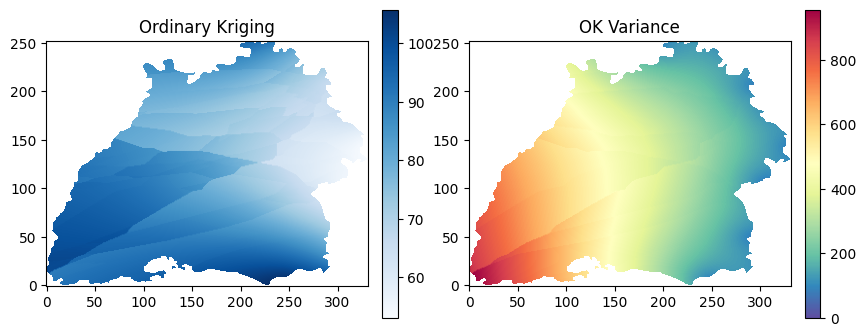

In [ ]:
import matplotlib.pyplot as plt
fig, _a = plt.subplots(1, 2, figsize=(10, 4))
axes = _a.flatten()

m = axes[0].imshow(np.flipud(pred.reshape((332, 252)).T), cmap='Blues', origin='lower')
plt.colorbar(m, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].set_title('Ordinary Kriging')

m = axes[1].imshow(np.flipud(var.reshape((332, 252)).T), cmap='Spectral_r', origin='lower',vmin=0)
plt.colorbar(m, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].set_title('OK Variance')



### use GSTools

Here we use GSTools, an alternative geostatistical library in Python, to perform Kriging. In production-ready code, use GSTools whenever performance matters, as it is by magnitudes faster than my custom solutions.

In [ ]:
krige = vario.to_gs_krige()

pred2, var2 = krige((grid_coords[:,0], grid_coords[:,1]))

Text(0.5, 1.0, 'OK Variance')

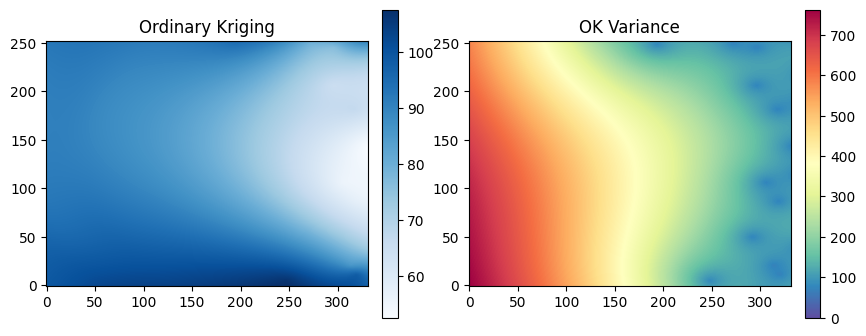

In [ ]:
import matplotlib.pyplot as plt
fig, _a = plt.subplots(1, 2, figsize=(10, 4))
axes = _a.flatten()

m = axes[0].imshow(np.flipud(pred2.reshape((332, 252)).T), cmap='Blues', origin='lower')
plt.colorbar(m, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].set_title('Ordinary Kriging')

m = axes[1].imshow(np.flipud(var2.reshape((332, 252)).T), cmap='Spectral_r', origin='lower',vmin=0)
plt.colorbar(m, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].set_title('OK Variance')

## SGS

Here is the implementation for Sequential Gaussian Simulation.

In [ ]:
class SGS:
  def __init__(self, iterations: int = 10, max_n: int = 15, batch_size: int = 25, verbose: bool = True):
    self.iterations = iterations
    self.max_n = max_n
    self.verbose = verbose
    self.batch_size = batch_size

    # set the stuff that has to be fitted
    self.variogram = None

  def fit(self, variogram: Variogram):
    self.variogram = variogram

    return self

  @property
  def _isvalid(self):
    if self.variogram is None:
      return False
    return True

  def _constrain_predict_field(self, grid_coords: np.ndarray):
    # container for the constrain values
    cond_vals = np.ones(len(grid_coords)) * np.nan

    for i, c in enumerate(self.variogram.coordinates):
      dists = cdist(grid_coords, [c]).flatten()
      cond_vals[dists.argmin()] = self.variogram.values[i]

    return cond_vals

  def simulate(self, grid_coords: np.ndarray, mask: np.ndarray = None, grid_shape = None, overview_level = None):
    # if no mask is given, we simulate on all values
    if mask is None:
      mask = np.ones(len(grid_coords), dtype=bool)

    # get the constrained field
    cond_vals = self._constrain_predict_field(grid_coords)

    # get all locations that need simulated values
    sim_coords = grid_coords[np.isnan(cond_vals) & mask]

    # check if we work with overviews
    if overview_level is not None and grid_shape is not None:
      sim_idx = list(self._create_overview(grid_shape, level=overview_level))
      sim_coords = grid_coords[sim_idx]

      # do an overview prediction
      cond_vals[sim_idx] = self._simulation_step(sim_coords, grid_coords, cond_vals)

    # now simulate
    # get all still existing NaNs
    na_idx = np.where(np.isnan(cond_vals) & mask)[0]

    # make a random shuffle of na_idx
    np.random.shuffle(na_idx)

    # go for each batch of na values
    for i in range(0, len(na_idx), self.batch_size):
      step_idx = na_idx[i : i+self.batch_size]

      # get the grid locations at idx
      grid = grid_coords[step_idx, :]

      # get the simulation
      prediction = self._simulation_step(grid, grid_coords, cond_vals)

      # now add them back to the cond_vals
      cond_vals[step_idx] = prediction
      if self.verbose:
        print(np.isnan(cond_vals).sum())

    return cond_vals

  def _create_overview(self, shape, level = 10):
      xsize, ysize = shape

      xstep = xsize // level
      ystep = ysize // level

      for x in range(0, xsize, xstep):
        for y in range(0, ysize, ystep):
          yield x * xsize + y

  def _simulation_step(self, sim_coords: np.ndarray, grid_coords: np.ndarray, cond_vals: np.array):
    # setup a kriging algorithm to fill the gaps
    # get anything that is not NaN
    na_idx = np.isnan(cond_vals)
    new_coords = grid_coords[~na_idx]
    new_vals = cond_vals[~na_idx]

    # either use GS tools or our implementation
    ok = OK(max_n=self.max_n, verbose=False)
    ok.fit(self.variogram, cond_coords=new_coords, cond_vals=new_vals)
    mean, var = ok.predict(sim_coords)

    # gs tools
    # krige = gs.Krige(self.variogram.to_gstools(), cond_pos=new_coords.T, cond_val=new_vals, fit_variogram=False)
    # mean, var = krige((sim_coords[:,0], sim_coords[:,1]))

    # finally pick random values from that distribution
    prediction = np.random.normal(mean, np.sqrt(var), size=len(sim_coords))

    # now add them back to the cond_vals
    return prediction


In [ ]:
sgs = SGS(batch_size=500, max_n=5).fit(vario)

field = sgs.simulate(grid_coords, mask)
field

Done


array([ nan,  nan,  nan, ...,  nan,  nan, 83.8])

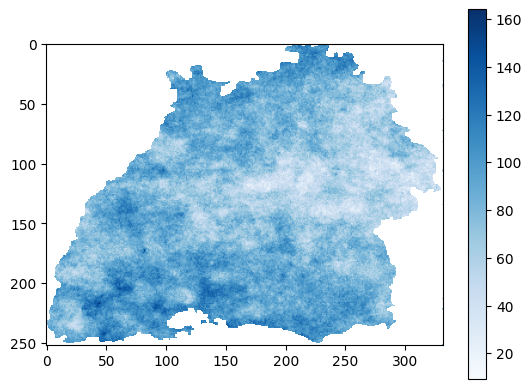

In [ ]:
plt.imshow(field.reshape((332, 252)).T, cmap='Blues')
plt.colorbar()

## GStatSim

GStatSim is another geostatistical Python library, specifically build for SGS.
It works well with SciKit-GStat.

Here, on colab it is not as fast as my implementation, as you can't enable multiprocessing on this platform. In production-ready code it might be the better solution.

In [8]:
df = pd.DataFrame(data=np.column_stack((vario.coordinates, vario.values)), columns=['x', 'y', 'prec'])
df

,x,y,prec
0,799337.127750,5.392993e+06,42.7
1,671079.603387,5.364009e+06,41.9
2,706811.572645,5.483523e+06,35.9
3,745498.069864,5.323736e+06,48.0
4,565358.348189,5.535627e+06,90.7
...,...,...,...
90,760575.560191,5.395650e+06,38.7
91,792724.923633,5.298400e+06,49.0
92,690343.179813,5.320897e+06,62.9
93,740281.311018,5.385159e+06,47.5


In [9]:
import gstatsim as gs

azimuth = 0
nugget = vario.parameters[-1]

# the major and minor ranges are the same in this example because it is isotropic
major_range = vario.parameters[0]
minor_range = vario.parameters[0]
sill = vario.parameters[1]
vtype = 'Spherical'

# save variogram parameters as a list
vario_pars = [azimuth, nugget, major_range, minor_range, sill, vtype]

k = 15         # number of neighboring data points used to estimate a given point
rad = 200000    # 200 km search radius

sim2 = gs.Interpolation.okrige_sgs(grid_coords, df, 'x', 'y', 'prec', k, vario_pars, rad)
sim2 = sim2.reshape(-1,1)
sim2

100%|██████████| 83664/83664 [59:28<00:00, 23.45it/s]


array([[ 94.80809918],
       [ 99.68486027],
       [100.56531783],
       ...,
       [ 95.36706391],
       [ 92.02402495],
       [ 99.62802095]])

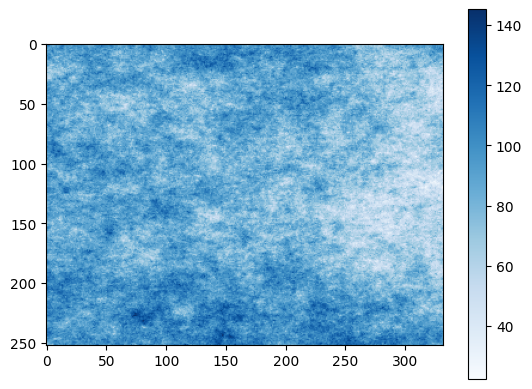

In [12]:
import matplotlib.pyplot as plt

plt.imshow(sim2.reshape((332, 252)).T, cmap='Blues')
plt.colorbar()